In [1]:
import logging
import yaml

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import asyncio

# import palpy

from lsst.ts import salobj

from lsst.ts.standardscripts.auxtel.attcs import ATTCS

from lsst.ts.idl.enums import ATPtg

%matplotlib inline

In [2]:
from astropy.utils import iers
iers.conf.auto_download = False

In [3]:
d = salobj.Domain()

In [4]:
atmcs = salobj.Remote(d, "ATMCS")
atptg = salobj.Remote(d, "ATPtg")
ataos = salobj.Remote(d, "ATAOS")
atpne = salobj.Remote(d, "ATPneumatics")
athex = salobj.Remote(d, "ATHexapod")
atdome = salobj.Remote(d, "ATDome", index=1)
atdomtraj = salobj.Remote(d, "ATDomeTrajectory")

In [5]:
await asyncio.gather(atmcs.start_task, 
                     atptg.start_task,
                     ataos.start_task,
                     atpne.start_task,
                     athex.start_task,
                     atdome.start_task,
                     atdomtraj.start_task)

[None, None, None, None, None, None, None]

AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 11 messages


# ATMCS

In [ ]:
await asyncio.sleep(5.)
print("Done")
await salobj.set_summary_state(atmcs, salobj.State.ENABLED)

# ATPtg

In [6]:
await asyncio.sleep(5.)
print("Done")
await atptg.tel_timeAndDate.next(flush=True, timeout=5)
await salobj.set_summary_state(atptg, salobj.State.ENABLED)

falling behind; queue contains 10 elements


Done


[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=243., elDegs=80.)

In [7]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [8]:
ra = Angle("03:58:01.7669489", unit=u.hour)
dec = Angle("-13:30:30.669770", unit=u.deg)
target_name="Gam Eri"
radec = ICRS(ra, dec)


In [ ]:
await atmcs.cmd_stopTracking.start()

In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [9]:
# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
print(curr_time_atptg)
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)

print("slew...")
# await atmcs.cmd_startTracking.start(timeout=10)
await atptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    targetInstance=ATPtg.TargetInstances.CURRENT,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=radec.ra.hour,
    declination=radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=180.-alt_az.alt.deg,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

RemoteEvent(ATAOS, 0, logMessage) falling behind; read 26 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 78 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 34 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 34 messages
RemoteTelemetry(ATMCS, 0, azEl_mountMotorEncoders) falling behind; read 34 messages
falling behind; queue contains 77 elements
falling behind; queue contains 76 elements


58738.28065532453


RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 26 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 34 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 34 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 26 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 34 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 34 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 34 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 34 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 34 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 34 messages
RemoteTelemetry(ATMCS, 0, nasymth_m3_mountMotorEncoders) falling behind; read 34 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 100 messages
Remote

slew...


RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 34 messages
RemoteEvent(ATPneumatics, 0, m1SetPressure) falling behind; read 26 messages
RemoteTelemetry(ATMCS, 0, mount_AzEl_Encoders) falling behind; read 34 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteEvent(ATPneumatics, 0, heartbeat) falling behind; read 34 messages
RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 35 messages
RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 35 messages
RemoteEvent(ATPtg, 0, mountDataWarning) falling behind; read 18 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 34 messages


In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [50]:
await atptg.cmd_stopTracking.start(timeout=10)

falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 95 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 95 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 95 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 95 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 95 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97

falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


In [ ]:
ss = await atdome.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
ss = await atdomtraj.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
await atdomtraj.cmd_enable.start()

In [10]:
async def wait_center():
    while True:
        opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
        if opt == 'n':
            print("Next point in the grid...")
            return 1
        elif opt == 'p':
            print("Previous point in the grid...")
            return -1
        elif opt == 't':
            print("Stopping test...")
            return 0
        elif opt == '?':
            print("""Options are:
            n - Go to next point in the grid.
            p - Go to previous point in the grid.
            t - Terminate test.
            """)
        else:
            print("Next point in the grid...")
            return 1

In [27]:
dalt_grid = np.arange(-0.25, +0.255, 0.05)+0.45
daz_grid = np.arange(-0.25, +0.255, 0.05)-0.4

In [33]:
await atptg.cmd_offsetAzEl.set_start(el=0.45*60.*60., 
                                     az=-0.4*60*60, 
                                         num=0)

RemoteTelemetry(ATDome, 1, position) falling behind; read 87 messages
falling behind; queue contains 38 elements
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 17 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 17 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 18 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 17 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 17 messages


In [28]:
grid_alt = np.zeros(len(dalt_grid)*len(daz_grid))
grid_az = np.zeros(len(dalt_grid)*len(daz_grid))

for i in range(len(daz_grid)):
    grid_alt[i*len(dalt_grid):(i+1)*len(dalt_grid)] += dalt_grid[::(-1)**i]
    grid_az[i*len(dalt_grid):(i+1)*len(dalt_grid)] += daz_grid[i]

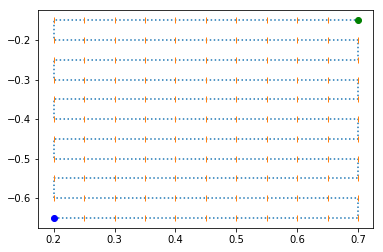

In [29]:
plt.plot(grid_alt, grid_az, ':')
plt.plot(grid_alt, grid_az, '|')
plt.plot(grid_alt[0], grid_az[0], 'bo')
plt.plot(grid_alt[-1], grid_az[-1], 'go')

In [30]:
start_from=0

In [32]:
print(f"Grid has {len(grid_alt)} pointings...")
print(f"Starting from {start_from}")

i = start_from
stop_at = 0

while i < len(grid_alt):
    
    print(f"GRID[{i}]: {grid_alt[i]} x {grid_az[i]}")

    await atptg.cmd_offsetAzEl.set_start(el=grid_alt[i]*60.*60., 
                                         az=grid_az[i]*60*60, 
                                         num=0)
    
    ret_val = await wait_center()

    if ret_val == 0:
        break
        
    i += ret_val
    
    if i < 0:
        print(f"Unwrapping index! (i={i})")
        i = 0

RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 25 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 25 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 24 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 24 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 58 messages


Grid has 121 pointings...
Starting from 0
GRID[0]: 0.2 x -0.65


falling behind; queue contains 57 elements
falling behind; queue contains 56 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Center telescope and choose action (press ?<enter>, for list of actions):  t


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Stopping test...


In [49]:
await atptg.cmd_offsetAzEl.set_start(el=0., 
                                     az=-15, 
                                     num=1)

RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 93 messages
RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 25 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 100 messages
RemoteEvent(ATPtg, 0, weatherDataApplied) falling behind; read 12 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


In [45]:
await atptg.cmd_offsetAzEl.set_start(el=15., 
                                     az=0, 
                                         num=1)

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 20 elements


In [ ]:
60-61

In [24]:
await asyncio.sleep(5)
off = await atptg.tel_guidingAndOffsets.next(flush=True, timeout=5)

RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 100 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements

In [25]:
print(off)

private_revCode: fd72d243, private_sndStamp: 1568271259.5892594, private_rcvStamp: 1568271296.5884497, private_seqNum: 535311, private_origin: 1, private_host: 1, timestamp: 58738.288155382936, iaa: 0.0, guideControlState: True, guideAutoClearState: True, guideGA: 0.0, guideGB: 0.0, userOffsetRA: -101.81873039331431, userOffsetDec: -1359.3954176659138, handsetOffsetRA: -2.202013338002239, handsetOffsetDec: 50.68011548636663, userCollOffsetCA: 0.0, userCollOffsetCE: 0.0, handsetCollOffsetCA: 0.0, handsetCollOffsetCE: 0.0, pointingOriginX: 0.0, pointingOriginY: 0.0, pointingOriginUserDX: 0.0, pointingOriginUserDY: 0.0, pointingOriginHandsetDX: 0.0, pointingOriginHandsetDY: 0.0
